# Cloud Optimized Geotiff Overview Resampling

When making cloud optimized geotiffs you can select the resampling method used to generate the overviews. This is most important when using software that renders from overviews (e.g QGIS, ArcGIS), particularly web tilers like Titiler. Different types of data can drastically change appearance when more zoomed out based on the method selected.

This notebook will loop over the overview resampling methods available in gdal. 

Notes:
GDAL 3.2 added the ability to specify the resampling method for the overviews specifically. GDAL 3.3 added a couple of new resampling methods. 

In [4]:
# Requires gdal >= 3.2 for Overview Resampling to work
# RMS resampling was added in GDAL 3.3
#!pip install -q -U rasterio>=1.2.3 folium
# TODO: investigate doing in memory with rio-cogeo
!mamba create -n gdal34 -c conda-forge gdal==3.4.3 rasterio ipykernel
!gdalinfo --version

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [49]:
import rasterio as rio
from rasterio.session import AWSSession
from rasterio.plot import show
import boto3
import subprocess
import os
import matplotlib.pyplot as plt

In [3]:
tile = '/projects/tmp/boreal/boreal_agb_202206061654544252_0076.tif'

In [68]:
# The original file does not contain overviews
!gdalinfo {tile}

Driver: GTiff/GeoTIFF
Files: /projects/tmp/boreal/boreal_agb_202206061654544252_0076.tif
       /projects/tmp/boreal/boreal_agb_202206061654544252_0076.tif.aux.xml
Size is 3000, 3000
Coordinate System is:
BOUNDCRS[
    SOURCECRS[
        PROJCRS["unknown",
            BASEGEOGCRS["unknown",
                DATUM["Unknown_based_on_GRS80_ellipsoid",
                    ELLIPSOID["GRS 1980",6378137,298.257222101004,
                        LENGTHUNIT["metre",1],
                        ID["EPSG",7019]]],
                PRIMEM["Greenwich",0,
                    ANGLEUNIT["degree",0.0174532925199433,
                        ID["EPSG",9122]]]],
            CONVERSION["Albers Equal Area",
                METHOD["Albers Equal Area",
                    ID["EPSG",9822]],
                PARAMETER["Latitude of false origin",40,
                    ANGLEUNIT["degree",0.0174532925199433],
                    ID["EPSG",8821]],
                PARAMETER["Longitude of false origin",180,
            

## Generate Overviews

Now lets generate overviews with each of the resampling methods possible in GDAL.

In [69]:
def generate_overview(orig, method):
    ''' 
    Create a copy of original GeoTiff as COG with different overview resampling method
    orig = the original GeotTiff
    method = the resampling method
    return the path to the new file
    '''
    #make sure the output folder exists
    os.makedirs('/projects/local_data/', exist_ok=True)
    outfile = f'/projects/local_data/{method}.tif'
    process = subprocess.run(['gdal_translate', '-of', 'COG',
                              '-co', f'OVERVIEW_RESAMPLING={method}',
                              '-co', 'COMPRESS=Deflate',
                              f'{orig}', f'{outfile}'
                             ], 
                         stdout=subprocess.PIPE, 
                         universal_newlines=True)
    print(process)

    return outfile

In [19]:
# This is a list of resampling methods that GDAL 3.4+ allows
resample_methods = ["AVERAGE", "NEAREST", "BILINEAR", "CUBIC", "CUBICSPLINE", "LANCZOS", "MODE", "RMS"]

In [21]:
# For each resampling method create a copy of the data creating overviews with the method.
files = [generate_overview(tile, method) for method in resample_methods] 

CompletedProcess(args=['gdal_translate', '-of', 'COG', '-co', 'OVERVIEW_RESAMPLING=AVERAGE', '-co', 'COMPRESS=Deflate', '/projects/tmp/boreal/boreal_agb_202206061654544252_0076.tif', '/projects/local_data/AVERAGE.tif'], returncode=0, stdout='Input file size is 3000, 3000\n0...10...20...30...40...50...60...70...80...90...100 - done.\n')
CompletedProcess(args=['gdal_translate', '-of', 'COG', '-co', 'OVERVIEW_RESAMPLING=NEAREST', '-co', 'COMPRESS=Deflate', '/projects/tmp/boreal/boreal_agb_202206061654544252_0076.tif', '/projects/local_data/NEAREST.tif'], returncode=0, stdout='Input file size is 3000, 3000\n0...10...20...30...40...50...60...70...80...90...100 - done.\n')
CompletedProcess(args=['gdal_translate', '-of', 'COG', '-co', 'OVERVIEW_RESAMPLING=BILINEAR', '-co', 'COMPRESS=Deflate', '/projects/tmp/boreal/boreal_agb_202206061654544252_0076.tif', '/projects/local_data/BILINEAR.tif'], returncode=0, stdout='Input file size is 3000, 3000\n0...10...20...30...40...50...60...70...80...90...

In [22]:
files

['/projects/local_data/AVERAGE.tif',
 '/projects/local_data/NEAREST.tif',
 '/projects/local_data/BILINEAR.tif',
 '/projects/local_data/CUBIC.tif',
 '/projects/local_data/CUBICSPLINE.tif',
 '/projects/local_data/LANCZOS.tif',
 '/projects/local_data/MODE.tif',
 '/projects/local_data/RMS.tif']

In [66]:
!gdalinfo {files[0]} | grep Overviews

  Overviews: 1500x1500, 750x750, 375x375
  Overviews: 1500x1500, 750x750, 375x375


## Compare the Results

Now that we've generated each of the overview methods we can plot the full data and each overview. The overviews are labelled by their magnification. Example and overview of 2, is the dimensions divided by 2. Typically in Cloud Optimized Geotiffs you will keep making overviews until the one of the dimensions is less than 512 pixels.

In [76]:
def compare_overviews(image):
    '''
    Read the original data, and overviews an plot them.
    TODO: limit the size of data read
    image = the path to input COG to read
    '''
    aws_session = AWSSession(boto3.Session())
    with rio.Env(aws_session):
        with rio.open(image, 'r') as src:
            oviews = src.overviews(1)
            #len of oviews + 1
            # generate object names to match
            # creat a plot of oviews +1 axes/columns
            # plot to each
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(16,4))
            ax_list = [ax1, ax2, ax3, ax4]
            show(src, ax=ax_list[0])
            ax_list[0].set_title("Full Resolution")
            ax_list[0].set_ylabel(os.path.basename(image))
            ax_list[0].xaxis.set_ticklabels([])
            ax_list[0].yaxis.set_ticklabels([])
            k = 1
            for oview in oviews:
                height = int(src.height // oview)
                width = int(src.width // oview)
                thumbnail = src.read(1, out_shape=(1, height, width))
                show(thumbnail, ax=ax_list[k])
                ax_list[k].set_title(f'{height}x{width}')
                ax_list[k].xaxis.set_ticklabels([])
                ax_list[k].yaxis.set_ticklabels([])
                k += 1

    return


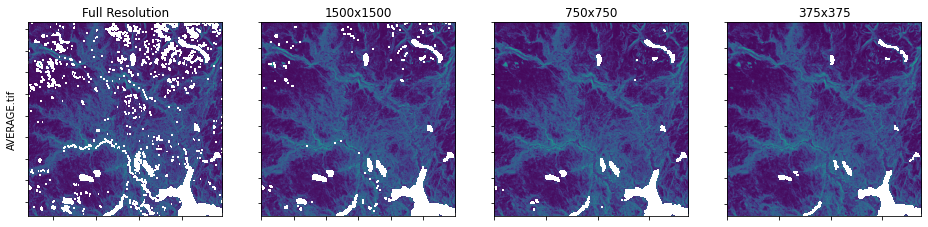

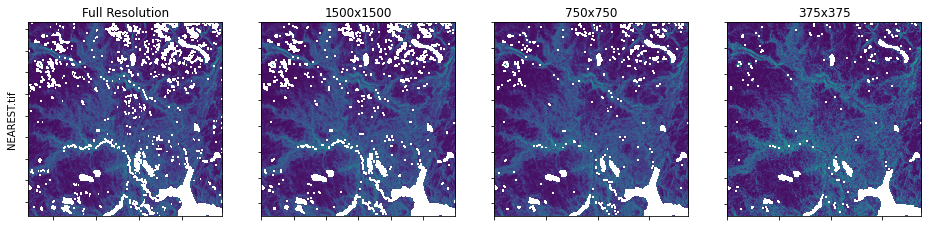

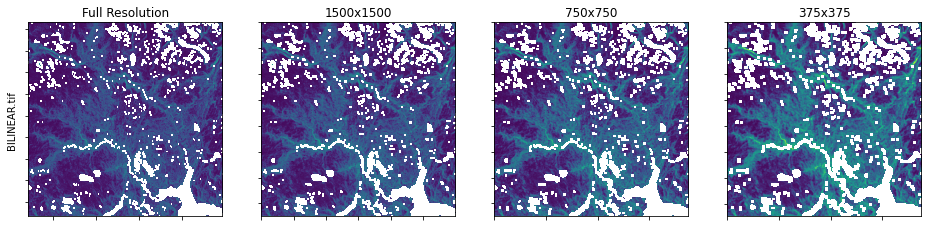

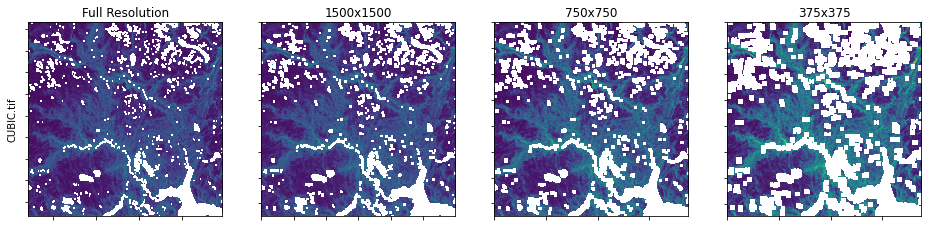

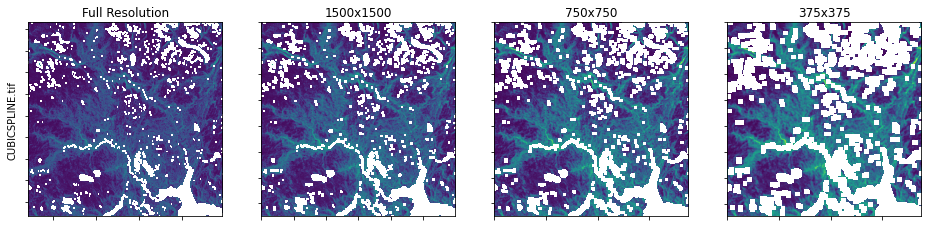

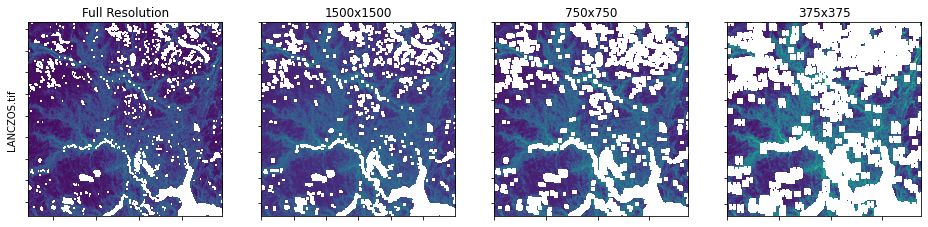

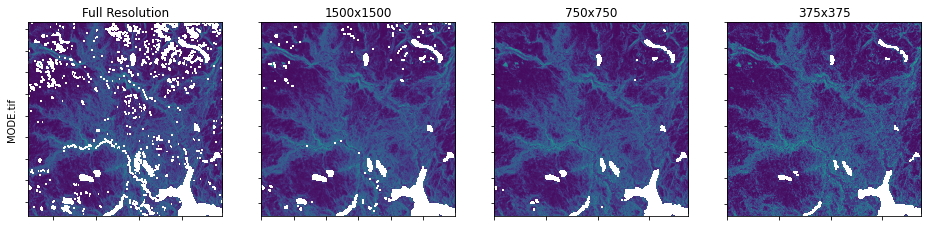

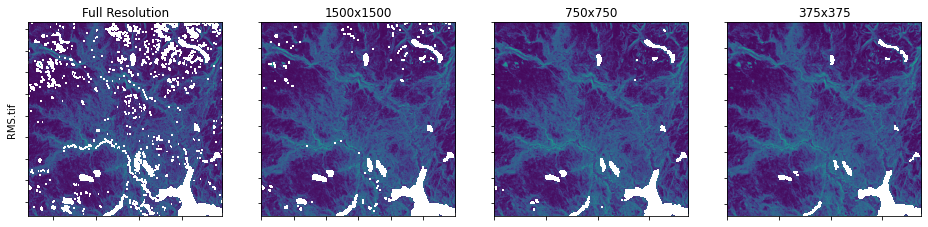

In [77]:
# plot all the variants
catch = [compare_overviews(file) for file in files]